# Transfer learning with a pretrained ConvNet

Lets try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. Simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
We will not (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

General machine learning workflow:

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
keras = tf.keras

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
import IPython.display as display
from PIL import Image


In [6]:
tf.__version__

'2.0.0'

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [7]:
import pathlib
#data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',fname='flower_photos', untar=True)
data_dir = 'data'
data_dir = pathlib.Path(data_dir)

After downloading (218MB), you should now have a copy of the flower photos available.

The directory contains 5 sub-directories, one per class:

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

34278

In [9]:
print(os.getcwd())
data_dir

/home/ergonyc/Projects/Insight/UTzappos50k


PosixPath('data')

In [10]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['Sneakers', 'Shoes', 'Boots'], dtype='<U8')

Each directory contains images of that type of flower. Here are some roses:

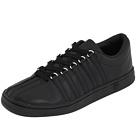

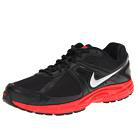

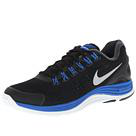

In [11]:
sneakers = list(data_dir.glob('Sneakers/*'))

for image_path in sneakers[:3]:
    display.display(Image.open(str(image_path)))

## Load using `tf.data`

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [12]:
BATCH_SIZE = 32
IMG_HEIGHT = 200
IMG_WIDTH = 200
IMG_SIZE = 200 # All images will be resized to 224x224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [13]:
train_dir = 'train'
train_dir = pathlib.Path(train_dir)

val_dir = 'validate'
val_dir = pathlib.Path(val_dir)

test_dir = 'test'
test_dir = pathlib.Path(test_dir)

train_list_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
validate_list_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(test_dir/'*/*'))

In [14]:
for f in train_list_ds.take(5):
  print(f.numpy())

b'train/Shoes/8078108.331813.jpg'
b'train/Shoes/8061588.351552.jpg'
b'train/Boots/8006606.254090.jpg'
b'train/Shoes/7698562.1145.jpg'
b'train/Sneakers/7887585.183092.jpg'


Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

In [15]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [16]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [17]:
# def format_example(image, label):
#   image = tf.cast(image, tf.float32)
#   image = (image/127.5) - 1
#   image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
#   return image, label

In [18]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = (img/127.5) - 1  # center values
  return img, label

In [19]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0])
      plt.axis('off')

In [20]:
CLASS_NAMES[1].title()

'Shoes'

Use `Dataset.map` to create a dataset of `image, label` pairs:


## Data preprocessing

The resulting `tf.data.Dataset` objects contain `(image, label)` pairs where the images have variable shape and 3 channels, and the label is a scalar.

print(train_ds)
Show the first two images and labels from the training set:

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixed input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [21]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
validate_labeled_ds = validate_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_labeled_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [22]:
for image, label in test_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (200, 200, 3)
Label:  [False False  True]


### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [23]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
print(STEPS_PER_EPOCH)
SHUFFLE_BUFFER_SIZE = 800

# train_dir = 'train'

# dataset = tf.data.Dataset.range(5) 
# dataset = dataset.map(lambda x: x**2) 
# dataset = dataset.cache() 

# this functionBATCHES implicitly
#     train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
#     validation_batches = validation.batch(BATCH_SIZE)
#     test_batches = test.batch(BATCH_SIZE)

def prepare_for_training(ds, cache=True, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  #ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds


def prepare_for_training2(ds, cache=True):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  
  if cache:
    print(cache)
    if isinstance(cache, str):
      print(f'making cache: {cache}')
      ds = ds.cache(cache)
    else:
      print('making cache')
      ds = ds.cache()

  # Repeat forever
  ds = ds.repeat()  # what does this do?

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

1072.0


In [24]:
print(train_labeled_ds)
print(validate_labeled_ds)
print(test_labeled_ds)


<DatasetV1Adapter shapes: ((200, 200, 3), (3,)), types: (tf.float32, tf.bool)>
<DatasetV1Adapter shapes: ((200, 200, 3), (3,)), types: (tf.float32, tf.bool)>
<DatasetV1Adapter shapes: ((200, 200, 3), (3,)), types: (tf.float32, tf.bool)>


In [25]:
# train_filecache_ds = prepare_for_training(train_labeled_ds, cache="./shoestrain.tfcache")
# test_filecache_ds = prepare_for_training(train_labeled_ds, cache="./shoestest.tfcache")
# validate_filecache_ds = prepare_for_training(validate_labeled_ds, cache="./shoesval.tfcache")


Apply this function to each item in the dataset using the map method:
This will also shuffle and batch

In [26]:
# train = train_filecache_ds.map(format_example)
# validation = validate_filecache_ds.map(format_example)  # 
# test = test_filecache_ds.map(format_example)

trcache="./train.tfcache"
valcache="./values.tfcache"
testcache="./test.tfcache"

train      = prepare_for_training(train_labeled_ds,cache=trcache).shuffle(SHUFFLE_BUFFER_SIZE)
validation = prepare_for_training(validate_labeled_ds,cache=valcache) #, cache="./shoestest.tfcache")
test       = prepare_for_training(test_labeled_ds,cache=testcache) #, cache="./shoestest.tfcache")


Inspect a batch of data:

In [27]:
trcache

'./train.tfcache'

In [28]:
# train_dir = pathlib.Path(train_dir)
# test_dir = 'test'
# test_dir = pathlib.Path(test_dir)

In [29]:
for image_batch, label_batch in validation.take(1):
    pass

image_batch.shape

TensorShape([32, 200, 200, 3])

In [30]:
for image_batch, label_batch in train.take(1):
    pass

image_batch.shape

ValueError: Tensor's shape (32, 224, 224, 3) is not compatible with supplied shape (None, 200, 200, 3)

In [ ]:
for image_batch, label_batch in test.take(1):
    pass

image_batch.shape

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
print(IMG_SHAPE)

In [45]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') #pooling = 'avg'

ResourceExhaustedError: OOM when allocating tensor with shape[1,1,576,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: block_13_project_1/kernel/Initializer/random_uniform/mul/

This feature extractor converts each `224x224x3` image into a `7x7x1280` block of features. See what it does to the example batch of images:

In [34]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

ResourceExhaustedError: OOM when allocating tensor with shape[32,29,29,192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pad]

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are three classes, lets use KL divergence `kullback_leibler_divergence`... if we move on to variational autoencoders we'll definatley want this

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = tf.keras.losses.kullback_leibler_divergence,#loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#kullback_leibler_divergence


In [ ]:
model.summary()

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

### Train the model

After training for 10 epochs, you should see ~96% accuracy.


In [ ]:
initial_epochs = 10

validation_steps=20

loss0,accuracy0 = model.evaluate(validation, steps = validation_steps)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train,
                    epochs=initial_epochs,
                    validation_data=validation,
                    validation_steps = validation_steps,
                    steps_per_epoch=STEPS_PER_EPOCH)

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Compile the model

Compile the model using a much lower learning rate.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.


In [ ]:
### CROSS VALIDATION WOULD BE KEWL.... 

from sklearn.model_selection import KFold

# Parameters
learning_rate = 0.01
batch_size = 500

train_x_all = mnist.train.images
train_y_all = mnist.train.labels
test_x = mnist.test.images
test_y = mnist.test.labels

def run_train(session, train_x, train_y):
  print "\nStart training"
  session.run(init)
  for epoch in range(10):
    total_batch = int(train_x.shape[0] / batch_size)
    for i in range(total_batch):
      batch_x = train_x[i*batch_size:(i+1)*batch_size]
      batch_y = train_y[i*batch_size:(i+1)*batch_size]
      _, c = session.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
      if i % 50 == 0:
        print "Epoch #%d step=%d cost=%f" % (epoch, i, c)


def cross_validate(session, split_size=5):
  results = []
  kf = KFold(n_splits=split_size)
  for train_idx, val_idx in kf.split(train_x_all, train_y_all):
    train_x = train_x_all[train_idx]
    train_y = train_y_all[train_idx]
    val_x = train_x_all[val_idx]
    val_y = train_y_all[val_idx]
    run_train(session, train_x, train_y)
    results.append(session.run(accuracy, feed_dict={x: val_x, y: val_y}))

  return results

with tf.Session() as session:
  result = cross_validate(session)
  print "Cross-validation result: %s" % result
  print "Test accuracy: %f" % session.run(accuracy, feed_dict={x: test_x, y: test_y})



## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

In [ ]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Define some parameters for the loader:

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_dir = 'train'
train_dir = pathlib.Path(train_dir)

test_dir = 'test'
test_dir = pathlib.Path(test_dir)


In [ ]:
train_data_gen = image_generator.flow_from_directory(directory=str(train_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

In [ ]:
test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Inspect a batch:

In [ ]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

The above `keras.preprocessing` method is convienient, but has three downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.